# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
# data_dir = '~/data'
# note: use full path on computer (not just ~)
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'

import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [3]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

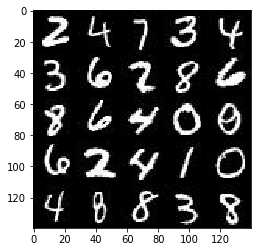

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

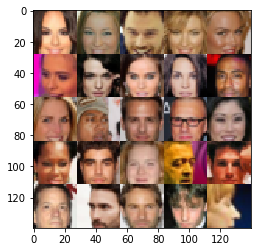

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same') 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same')
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape first layer as 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (7x7x128)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Third layer as (14x14x64)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 #For one-sided label smoothing (to prevent the discriminator from becoming too strong) 
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.9371


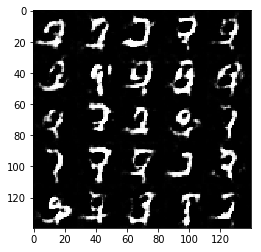

Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.9910


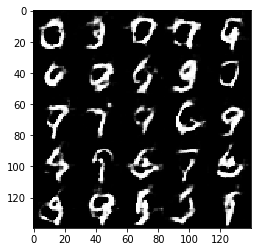

Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 0.8676


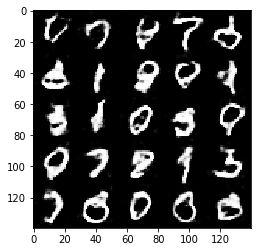

Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 1.0166


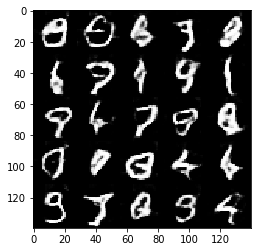

Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.9721


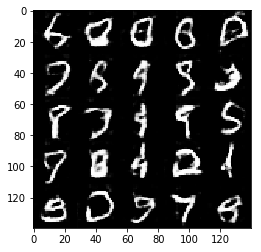

Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 1.0911


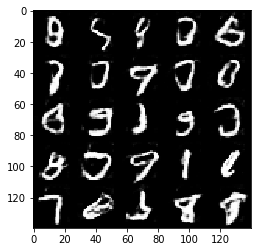

Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 1.0272


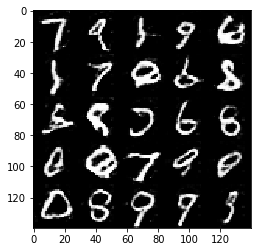

Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 1.3767
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.8066


In [21]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.8763


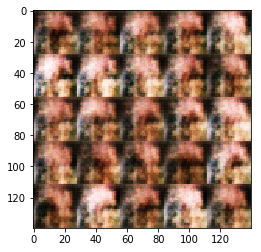

Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.2956


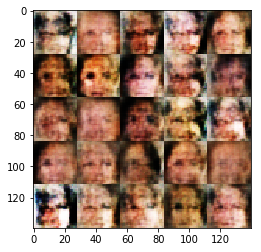

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.6684


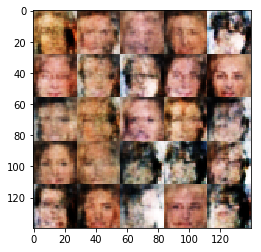

Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9267


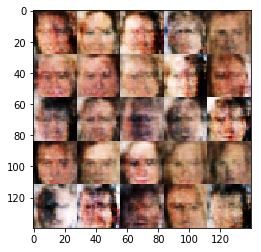

Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.0727


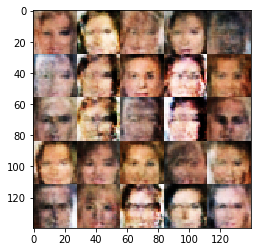

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.1681


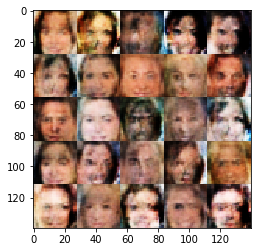

Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.1367


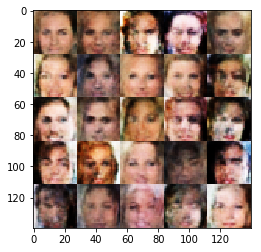

Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.7038
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8585


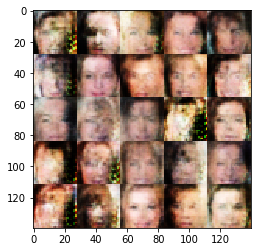

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8273


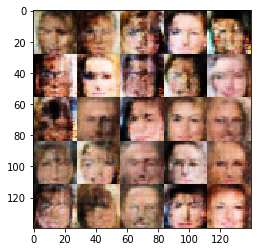

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9275


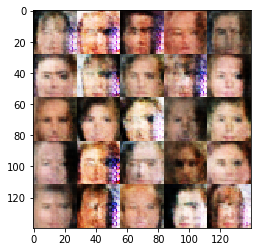

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8181


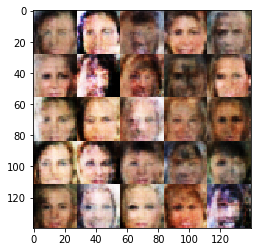

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.8688... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7982


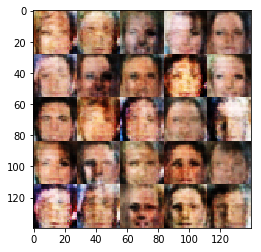

Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8257


In [22]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Porject notes:__ I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine.  FOr the project, we're looking at performance with just 1 epoch.  

Faces are recognizable in a single epoch.  I have tried beta1 values of 0.9, 0.5 and also lower values. 0.2 is good, as is 0.3.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.